# PWV effects on SN Magnitude

This notebook demonstrates the effects of PWV absorption on the apparent magnitude of SNe.


In [4]:
import sys
sys.path.insert(0, '../')

import itertools
from copy import copy
from pathlib import Path

import numpy as np
from tqdm import tqdm

import sncosmo
from matplotlib import pyplot as plt
from snat_sim import models, sn_magnitudes, reference_stars, plotting, constants as const
from snat_sim.filters import register_lsst_filters
from tests.mock import create_cadence


In [5]:
fig_dir = Path('.') / 'figs' / 'delta_mag'
fig_dir.mkdir(exist_ok=True, parents=True)
register_lsst_filters(force=True)


We set some parameters for later use and create a Model that has a temporally static PWV transmission effect.

In [6]:
_source = 'salt2-extended'
model_without_pwv = models.SNModel(_source)

model_with_pwv = models.SNModel(_source)
model_with_pwv.add_effect(models.StaticPWVTrans(), '', 'obs')

pwv_vals = np.arange(0, 11)
z_vals = np.arange(.01, 1.05, .05)

# We make sure to use bands without an Atm. component
bands = [f'lsst_hardware_{b}' for b in 'grizy']


## Spectral Template

The effect of PWV absorption is fundamentally dependent on the interplay between the SED of the effected object and the PWV transmission function. For this work we consider an extend version of the Salt2 spectral template. We visualize the template as a reference. For easier visualization, the figure below includes dilation effects but does not include the change in flux density due to distance.


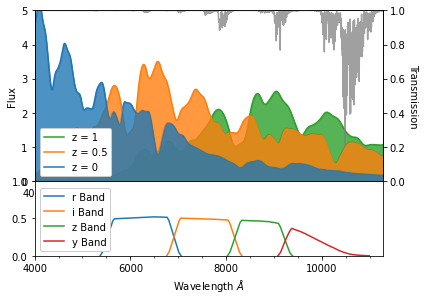

In [7]:
_ = plotting.plot_spectral_template('salt2-extended', np.arange(4000, 10000), [0, .5, 1], pwv=4)
plt.savefig(fig_dir / 'spectral_template.pdf', bbox_inches='tight')


## Apparent magnitude

We start by considering the direct impact of PWV absorption on simulated SN Ia magnitudes. Apparent magnitudes are simulated for multiple bands, redshifts, and PWV concentrations.


In [8]:
tabulated_mag = sn_magnitudes.tabulate_mag(model_with_pwv, pwv_vals, z_vals, bands)


Tabulating Mag: 100%|██████████| 1155/1155 [00:01<00:00, 660.13it/s]


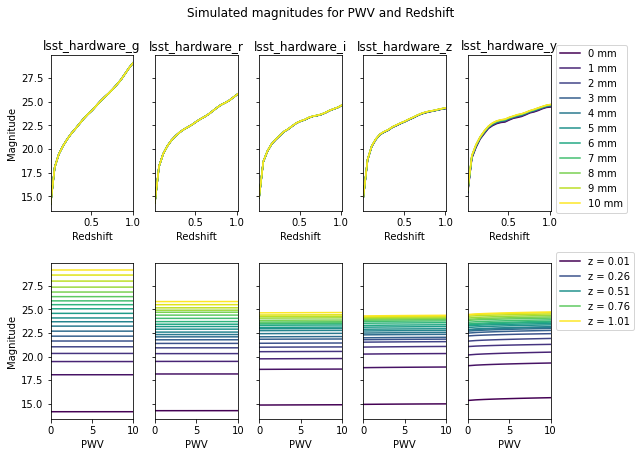

In [9]:
fig, axes = plotting.plot_magnitude(tabulated_mag, pwv_vals, z_vals)
_ = fig.suptitle('Simulated magnitudes for PWV and Redshift', y=1.05)
plt.savefig(fig_dir / 'tabulated_magnitudes.pdf', bbox_inches='tight')


To better understand the impact of PWV, we estimate the change in apparent magnitude due to PWV. Although we could measure this change relative to PWV=0, a more physically motivated approach is to use a fiducial atmosphere with a non-zero PWV component:

$$\Delta m = m(\text{PWV}, z) - m(\text{PWV}_f, z)$$

We also determine the slope in the apparent magnitude as an estimate for how sensitive our simulated observations are to PWV fluctuations:

$$\frac{\Delta m}{\Delta \text{PWV}}(z) = \frac{m(\text{PWV}_2, z) - m(\text{PWV}_1, z)}{\text{PWV}_2 - \text{PWV}_1}$$

Here PWV$_1$ and PWV$_2$ are chosen to be equidistant to PWV$_f$. We take note of the chosen PWV reference values in the following cell:


In [10]:
reference_pwv_config = sn_magnitudes.get_config_pwv_vals()
print(reference_pwv_config)


{'reference_pwv': 4.0, 'slope_start': 2.0, 'slope_end': 6.0}


We tabulate values for $\Delta m$ and $\frac{\Delta m}{\Delta \text{PWV}}(z)$. 

In [11]:
tabulated_fiducial_mag = sn_magnitudes.tabulate_fiducial_mag(
        model_with_pwv, z_vals, bands, reference_pwv_config)

tabulated_delta_mag, tabulated_slope = sn_magnitudes.calc_delta_mag(
    tabulated_mag, tabulated_fiducial_mag, reference_pwv_config)


Tabulating Mag: 100%|██████████| 315/315 [00:00<00:00, 689.67it/s]


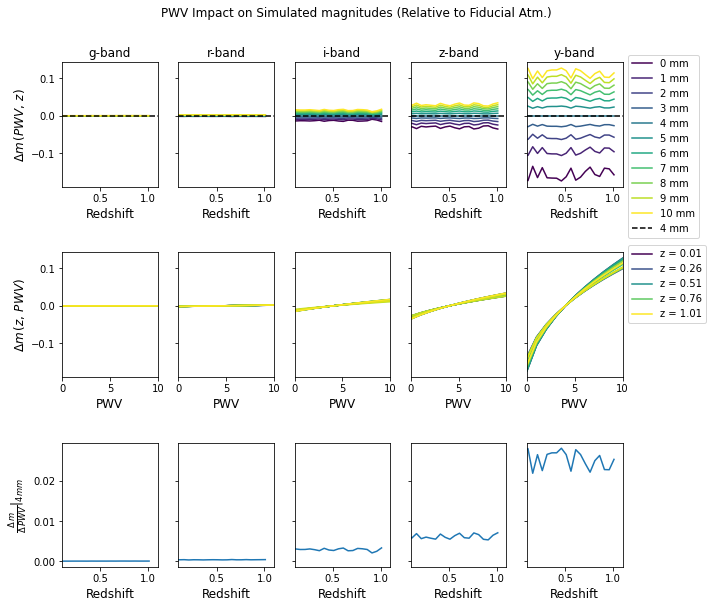

In [12]:
fig, axes = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    tabulated_delta_mag, 
    tabulated_slope, 
    bands)

_ = fig.suptitle('PWV Impact on Simulated magnitudes (Relative to Fiducial Atm.)', y=1.05)
plt.savefig(fig_dir / 'tabulated_pwv_effects.pdf', bbox_inches='tight')


---

**Sanity Check:** We expect to see the following trends in the above plot:
- The bluer bands should have minimal PWV impact. 
- The size of $\Delta$m should be largest for the redder bands. 
- The slope in $\Delta$m should be almost zero in the bluer bands.
- $\Delta$m should be zero for the fiducial PWV value.
- The general shape of the $\Delta m$ vs PWV curves should change as a function of different features passing through each band. This means the shape of the curves should be different in each band.

---

## Change in Magnitude With Fitting

Instead of tabulating the simulating magnitude, we can instead consider the change in magnitude by simulating light-curves with PWV effects and then fitting a model without a PWV component. For simplicity we use a densely sampled, uniform cadence.

In [13]:
cadence = create_cadence(bands=bands)
cadence


  time        band        gain  skynoise    zp   zpsys 
------- --------------- ------- -------- ------- ------
  -20.0 lsst_hardware_g     1.0      0.0    25.0     AB
  -20.0 lsst_hardware_y     1.0      0.0    25.0     AB
  -20.0 lsst_hardware_i     1.0      0.0    25.0     AB
  -20.0 lsst_hardware_z     1.0      0.0    25.0     AB
  -20.0 lsst_hardware_r     1.0      0.0    25.0     AB
  -19.0 lsst_hardware_z     1.0      0.0    25.0     AB
  -19.0 lsst_hardware_r     1.0      0.0    25.0     AB
  -19.0 lsst_hardware_y     1.0      0.0    25.0     AB
  -19.0 lsst_hardware_g     1.0      0.0    25.0     AB
  -19.0 lsst_hardware_i     1.0      0.0    25.0     AB
    ...             ...     ...      ...     ...    ...
   49.0 lsst_hardware_y     1.0      0.0    25.0     AB
   49.0 lsst_hardware_i     1.0      0.0    25.0     AB
   49.0 lsst_hardware_r     1.0      0.0    25.0     AB
   49.0 lsst_hardware_z     1.0      0.0    25.0     AB
   49.0 lsst_hardware_g     1.0      0.0    25.0

In [16]:
def iter_lcs_fixed_snr(cadence, model, pwv_arr, z_arr, snr = 10, verbose = True):
    """Iterator over SN light-curves for combination of PWV and z values
    
    Args:
        cadence (ObservedCadence): Observational cadence
        model           (SNModel): The sncosmo model to use in the simulations
        pwv_arr        (np.array): Array of PWV values
        z_arr          (np.array): Array of redshift values
        snr          (float, int): Signal to noise ratio
        verbose            (bool): Show a progress bar
        
    Yields:
        An Astropy table for each PWV and redshift
    """

    model = copy(model)
    iter_total = len(pwv_arr) * len(z_arr)
    arg_iter = itertools.product(pwv_arr, z_arr)
    for pwv, z in tqdm(arg_iter, total=iter_total, desc='Light-Curves', disable=not verbose):
        model.set(t0=0.0, pwv=pwv, z=z)
        model.set_source_peakabsmag(const.betoule_abs_mb, 'standard::b', 'AB', cosmo=const.betoule_cosmo)
        yield model.simulate_lc_fixed_snr(cadence, snr)


In [17]:
# Iterator over simulated light-curves
light_curves = iter_lcs_fixed_snr(cadence, model_with_pwv, pwv_vals, z_vals)

# Fit light curves
vparams = ['x0', 'x1', 'c']
fitted_mag, fitted_params = sn_magnitudes.fit_mag(
        model_without_pwv, light_curves, vparams, bands, pwv_vals, z_vals)

# Get fiducial mag
fitted_fiducial_mag, fitted_fiducial_params = sn_magnitudes.fit_fiducial_mag(
        model_with_pwv, model_without_pwv, cadence, vparams, z_vals, bands, reference_pwv_config)


Light-Curves: 100%|██████████| 231/231 [00:57<00:00,  4.05it/s]


NameError: name 'lc_simulation' is not defined

Here we visualize the fitted, uncorrected (i.e. without any stretch / color correction) magnitudes.

In [ ]:
fig, axes = plotting.plot_magnitude(fitted_mag, pwv_vals, z_vals)
_ = fig.suptitle('Fitted Magnitude (Uncorrected)', y=1.05)
plt.savefig(fig_dir / 'fitted_magnitudes.pdf', bbox_inches='tight')


---

**Sanity Check:** The fitted light-curves are constructed to have a dense, uniform sampling. As a result, the fitted magnitude should look extremely similar to the tabulated magnitudes from earlier.

---

We expect to see minimal differences between the tabulated, and fitted magnitudes in each band. However, we do expect to variation in the fitted stretch and color.

In [ ]:
fig, axes = plotting.plot_fitted_params(fitted_params, pwv_vals, z_vals, bands)
_ = fig.suptitle('Fitted Parameters', y=1.05)
plt.savefig(fig_dir / 'fitted_parameters.pdf', bbox_inches='tight')


We look at the impact of PWV on the fitted magnitude.

In [ ]:
corrected_delta_mag, corrected_slope = sn_magnitudes.calc_delta_mag(
    fitted_mag, fitted_fiducial_mag, reference_pwv_config)


In [ ]:
fig, axes = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    corrected_delta_mag, 
    corrected_slope, 
    bands)

_ = fig.suptitle('PWV Impact on Fitted Magnitudes (Relative to Fiducial Atm.)', y=1.05)
plt.savefig(fig_dir / 'fitted_pwv_effects.pdf', bbox_inches='tight')


Next we add in the alpha and beta parameters from the fit.

In [ ]:
# Determine corrected magnitude from fits
corrected_mag = {}
corrected_fiducial_mag = {}
for band in bands:
    corrected_mag[band] = sn_magnitudes.correct_mag(
        model_with_pwv, fitted_mag[band], fitted_params[band])

    # Get fiducial mag (calibrated)
    corrected_fiducial_mag[band] = sn_magnitudes.correct_mag(
        model_with_pwv, fitted_fiducial_mag[band], fitted_fiducial_params[band])


In [ ]:
corrected_delta_mag, corrected_slope = sn_magnitudes.calc_delta_mag(
        corrected_mag, corrected_fiducial_mag, reference_pwv_config)


In [ ]:
fig, axes = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    corrected_delta_mag, 
    corrected_slope, 
    bands)

_ = fig.suptitle('PWV Impact on Calibrated Magnitudes (Relative to Fiducial Atm.)', y=1.05)
plt.savefig(fig_dir / 'corr_pwv_effects.pdf', bbox_inches='tight')


---

**Sanity Check:** Unlike some of the previous plots we have made, we expect the overall shape of the the $\Delta m$ vs $z$ curves to be similar across bands. Since we are considering fitted magnitudes in the above plot, the presence of PWV impacts the fitted model parameters, and then the model enforces cross-band uniformity when we evaluate the synthetic photometry.

---

## Relative to a Reference Star

In practice flux values are calibrated relative to a reference star. To understand how PWV effects SNe fluxes during this process, we normalize the reference star flux to it's respective fluxes through PWV=0 and take the difference (SNe flux / normalized reference star flux).


In [ ]:
def iter_light_curve_iter_with_ref(model, pwv_arr, z_arr, spectral_types=('G2', 'M5', 'K2')):
    
    observations = lc_simulation.create_observations_table(bands=bands)
    light_curves = lc_simulation.iter_lcs_fixed_snr(observations, model, pwv_arr, z_arr)
    for lc in light_curves:
        pwv = lc.meta['pwv']
        yield reference_stars.divide_ref_from_lc(lc, pwv=pwv, spectral_types=spectral_types)
    

In [ ]:
vparams = ['x0', 'x1', 'c']
light_curves_with_ref = iter_light_curve_iter_with_ref(model_with_pwv, pwv_vals, z_vals)
fitted_mag_with_ref, fitted_params_with_ref = sn_magnitudes.fit_mag(
        model_without_pwv, light_curves_with_ref, vparams, bands, pwv_vals, z_vals, bounds={'t0': (-1, 1)})


In [ ]:
fig, axes = plotting.plot_magnitude(fitted_mag_with_ref, pwv_vals, z_vals)
_ = fig.suptitle('Magnitude from fit to SN - Ref', y=1.05)


In [ ]:
fig, axes = plotting.plot_fitted_params(fitted_params_with_ref, pwv_vals, z_vals, bands)
_ = fig.suptitle('Parameters from fit to SN - Ref', y=1.05)


In [ ]:
# Determine corrected magnitude from fits
corrected_mag_with_ref = {}
for band in bands:
    corrected_mag_with_ref[band] = sn_magnitudes.correct_mag(
        model_with_pwv, fitted_mag_with_ref[band], fitted_params_with_ref[band])


In [ ]:
fig, axes = plotting.plot_magnitude(corrected_mag_with_ref, pwv_vals, z_vals)
_ = fig.suptitle('Corrected Magnitude from fit to SN - Ref', y=1.05)


In [ ]:
_pwv_list = list(pwv_vals)
reference_idx = _pwv_list.index(reference_pwv_config['reference_pwv'])
slope_start_idx = _pwv_list.index(reference_pwv_config['slope_start'])
slope_end_idx = _pwv_list.index(reference_pwv_config['slope_end'])

corrected_fiducial_mag_with_ref = dict()
for band in bands:
    _mag_arr = corrected_mag_with_ref[band]
    _ref_mag = _mag_arr[reference_idx]
    _start_mag = _mag_arr[slope_start_idx]
    _end_mag = _mag_arr[slope_end_idx]
    
    corrected_fiducial_mag_with_ref[band] = [_start_mag, _ref_mag, _end_mag]  
    

In [ ]:
corrected_delta_mag_with_ref, corrected_slope_with_ref = sn_magnitudes.calc_delta_mag(
        corrected_mag_with_ref, corrected_fiducial_mag_with_ref, reference_pwv_config)

fig, axes = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    corrected_delta_mag_with_ref, 
    corrected_slope_with_ref, 
    bands)

fig.suptitle('PWV Impact on Corrected Magnitude from fit to SN - Ref', y=1.05)
plt.savefig(fig_dir / 'corr_pwv_effects_with_ref_star.pdf', bbox_inches='tight')


## Impact on Distance Modulus

Here we consider the impact of PWV on $\mu$ using fits to SNe flux after calibration to the reference star. We note that there is a disagreement between the distance module calculated by an astropy Cosmology object, and by an SNCosmo model that has been calibrated using that same cosmology. For consistency, we exclusively use SNCosmo values of $\mu$.

### Results without using a reference star

In [ ]:
# The params are band independent so we use the r-band values
calib_factor = sn_magnitudes.calc_calibration_factor_for_params(
    model_without_pwv, fitted_params['lsst_hardware_r'])

fitted_mu = sn_magnitudes.calc_mu_for_params(
    model_without_pwv, fitted_params['lsst_hardware_r'])


In [ ]:
# Account for (what I think is) a numerical error between astropy and sncosmo
numerical_error_offset = fitted_mu[0] - constants.betoule_cosmo.distmod(z_vals).value

plotting.plot_delta_mu(fitted_mu - numerical_error_offset, pwv_vals, z_vals)


In [ ]:
plotting.plot_delta_mu(fitted_mu + calib_factor - numerical_error_offset, pwv_vals, z_vals)
plt.savefig(fig_dir / 'mu_pwv_effects.pdf', bbox_inches='tight')


### Results with a reference star

In [ ]:
calib_factor_with_ref = sn_magnitudes.calc_calibration_factor_for_params(
    model_without_pwv, fitted_params_with_ref['lsst_hardware_r'])

fitted_mu_with_ref = sn_magnitudes.calc_mu_for_params(
    model_without_pwv, fitted_params_with_ref['lsst_hardware_r'])


In [ ]:
numerical_error_offset_ref = fitted_mu_with_ref[0] - constants.betoule_cosmo.distmod(z_vals).value
plotting.plot_delta_mu(fitted_mu_with_ref - numerical_error_offset_ref, pwv_vals, z_vals)


In [ ]:
plotting.plot_delta_mu(fitted_mu_with_ref + calib_factor_with_ref - numerical_error_offset_ref, pwv_vals, z_vals)
plt.savefig(fig_dir / 'mu_pwv_effects_with_ref.pdf', bbox_inches='tight')


## Change in Color

In [ ]:
colors = list(zip(bands[:-1], bands[1:]))

In [ ]:
plotting.plot_delta_colors(pwv_vals, z_vals, tabulated_mag, colors)
plt.savefig(fig_dir / 'delta_tabulated_corrected_color.pdf', bbox_inches='tight')


In [ ]:
plotting.plot_delta_colors(pwv_vals, z_vals, corrected_mag, colors)
plt.savefig(fig_dir / 'delta_fitted_corrected_color.pdf', bbox_inches='tight')


In [ ]:
plotting.plot_delta_colors(pwv_vals, z_vals, corrected_mag_with_ref, colors)
plt.savefig(fig_dir / 'delta_fitted_color_with_ref.pdf', bbox_inches='tight')
